In [ ]:
import numpy as np
import scipy.sparse as spa
import os
import scipy.sparse as spa
from scipy.sparse.linalg import eigsh, splu
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import AutoMinorLocator

def epsilon_nk_cosx_pot(k=0, a=10, v0=1.0, ngx=10, nbnds=5, Ngmax=1):
    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    b   = 2*np.pi / a
    Gx  = Gx * b
    k  *= b

    lambda_kG = 0.5 * (k + Gx)**2
    Hij = np.diag(lambda_kG)

    nn = range(ngx)
    for ii in range(1,Ngmax+1):
        Hij[nn[:-ii], nn[ii:]] = v0
        Hij[nn[:-(ngx-ii)], nn[ngx-ii:]] = v0

        Hij[nn[ii:], nn[:-ii]] = v0
        Hij[nn[(ngx-ii):], nn[:-(ngx-ii)]] = v0
    
    E, phi = np.linalg.eigh(Hij) 

    return E[:nbnds], phi[:,:nbnds].T

def get_bloch_wavepacket_gaussian_envelop(k0, sigma_k, nk=20, Nsigma=10):
    assert -0.5 <= k0 <= 0.5

    delta_k = Nsigma * sigma_k
    ktmp    = np.linspace(0, delta_k, nk, endpoint=True)
    k1      = np.r_[-ktmp[::-1][:-1], ktmp]

    k2 = k1 + k0
    k2[k2 >= 0.5] -= 1.0
    k2[k2 <=-0.5] += 1.0
    fk = np.sqrt(1 / np.sqrt(np.pi) / sigma_k) * np.exp(-k1**2/(2*sigma_k**2))

    return k2, fk

def construct_blochwp_cosx_pot(x, kwp, fk, n0=0, 
        v0=0.05, a=1, nbnds=5, ngx=20):
    Nx  = x.size
    b   = 2*np.pi / a

    Cng = []
    for k in kwp:
        E, C = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
        Cng.append(C)
    Cng = np.array(Cng)

    Gx = np.arange(ngx, dtype=int)
    Gx[ngx // 2 + 1:] -= ngx

    bloch_wp = np.zeros(Nx, dtype=complex)
    for ik, k in enumerate(kwp):
        for ig, g in enumerate(Gx):
            bloch_wp[:] += np.exp(1j*(k+g)*x*b) * fk[ik] * Cng[ik,n0,ig]
    bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))

    return bloch_wp

def CrankNicolson(psi0, V, x, dt, N=100, print_norm=False):
    J  = x.size - 1
    dx = x[1] - x[0]

    V = spa.diags(V)
    O = np.ones(J+1)
    T = (-1 / 2 / dx**2) * spa.spdiags([O, -2*O, O], [-1, 0, 1], J+1, J+1)

    U2 = spa.eye(J+1) + (1j * 0.5 * dt) * (T + V)
    U1 = spa.eye(J+1) - (1j * 0.5 * dt) * (T + V)
    U2 = U2.tocsc()
    LU = splu(U2)

    PSI_t = np.zeros((J+1, N), dtype=complex)
    PSI_t[:, 0] = psi0

    for n in range(N-1):
        b            = U1.dot(PSI_t[:,n])
        PSI_t[:,n+1] = LU.solve(b)
        if print_norm:
            print(n, np.trapz(np.abs(PSI_t[:,n+1])**2, x))

    return PSI_t



In [ ]:
a     = 10
b     = 2*np.pi / a
nkpts = 120
nbnds = 5
k0    = np.linspace(-0.5, 0.5, nkpts, endpoint=True)

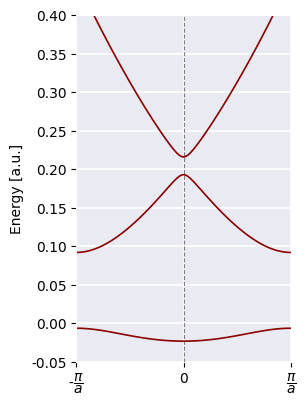

In [ ]:
plt.style.use('default')
mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(3.0, 4.0))
ax = plt.subplot()

ax.set_facecolor('#EAEAF2')
ax.grid(True, color='white', linewidth=1.2, linestyle='-')
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_color('white')

v0 = 0.05
Enk = np.array([
    epsilon_nk_cosx_pot(k, a, v0, nbnds=nbnds, Ngmax=1)[0]
    for k in k0
])

ax.axvline(x=0, color='gray', ls='--', lw=0.8)

deep_red = '#C44E52'
dark_red = '#8B0000'
deep_blue = '#4C72B0'
deep_green = '#55A868'

for ii in range(Enk.shape[1]): 
    ax.plot(k0, Enk[:,ii], color=dark_red, lw=1.2)

ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-v0, 0.4)

ax.set_xticks([-0.5, 0, 0.5])
ax.set_xticklabels([r'-$\dfrac{\pi}{a}$', r'$0$', r'$\dfrac{\pi}{a}$'])

ax.set_ylabel('Energy [a.u.]', labelpad=5)

plt.tight_layout(pad=0.5)
plt.show()

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_42805/4202974891.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))


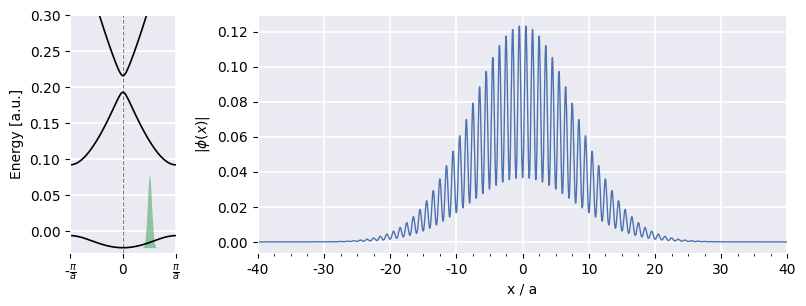

In [137]:
a  = 10
b  = 2*np.pi / a
v0 = 0.05

n0       = 0
k0       = 0.25
sigma_k  = 0.02
nbnds    = 5
ngx      = 20
kwp, fk  = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k=sigma_k,
        nk=100, Nsigma=10)

k_1d_bz = np.linspace(-0.5, 0.5, 120)
Enk = np.array([
    epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)[0]
    for k in k_1d_bz
])

Nc       = 160
L        = Nc * a
Nx       = 3999
x        = np.linspace(-L/2, L/2, Nx)
dx       = x[1] - x[0]
bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=20)

mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8.0, 3.0))

axes = fig.subplot_mosaic(
    [[0, 1]],
    empty_sentinel=None,
    height_ratios=[1],
    width_ratios=[1, 5],
)
axes_list = [axes[ii] for ii in range(2)]

for ax in axes_list:
    ax.set_facecolor('#EAEAF2')
    ax.grid(True, color='white', linewidth=1.2, linestyle='-')
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color('white')

ax = axes_list[0]
ax.axvline(x=0, lw=0.8, ls='--', color='gray')

emin = Enk.min()

ax.fill_between(
    kwp, emin, fk * np.sqrt( np.sqrt(np.pi) * sigma_k) * 0.1 + emin,
    lw=0.0, color=deep_green, alpha=0.6
)

for ii in range(nbnds):
    ax.plot(k_1d_bz, Enk[:,ii], color='black', lw=1.2)

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.5, 0, 0.5], [r'-$\frac{\pi}{a}$', '0',  r'$\frac{\pi}{a}$'])
ax.set_ylim(-0.03, 0.30)
ax.set_ylabel('Energy [a.u.]')

ax = axes_list[1]
ax.plot(x / a, np.abs(bloch_wp), color=deep_blue, lw=1.0)

ax.xaxis.set_minor_locator(AutoMinorLocator(n=4))
ax.set_xlim(-40, 40)
ax.set_ylabel(r'|$\phi(x)|$')
ax.set_xlabel(r'x / a')

plt.tight_layout(pad=0.5, w_pad=1.0)
plt.show()

/var/folders/x1/k24pyyhs04bb7784s3d75spr0000gn/T/ipykernel_42805/4202974891.py:66: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bloch_wp /= np.sqrt(np.trapz(np.abs(bloch_wp)**2, x))


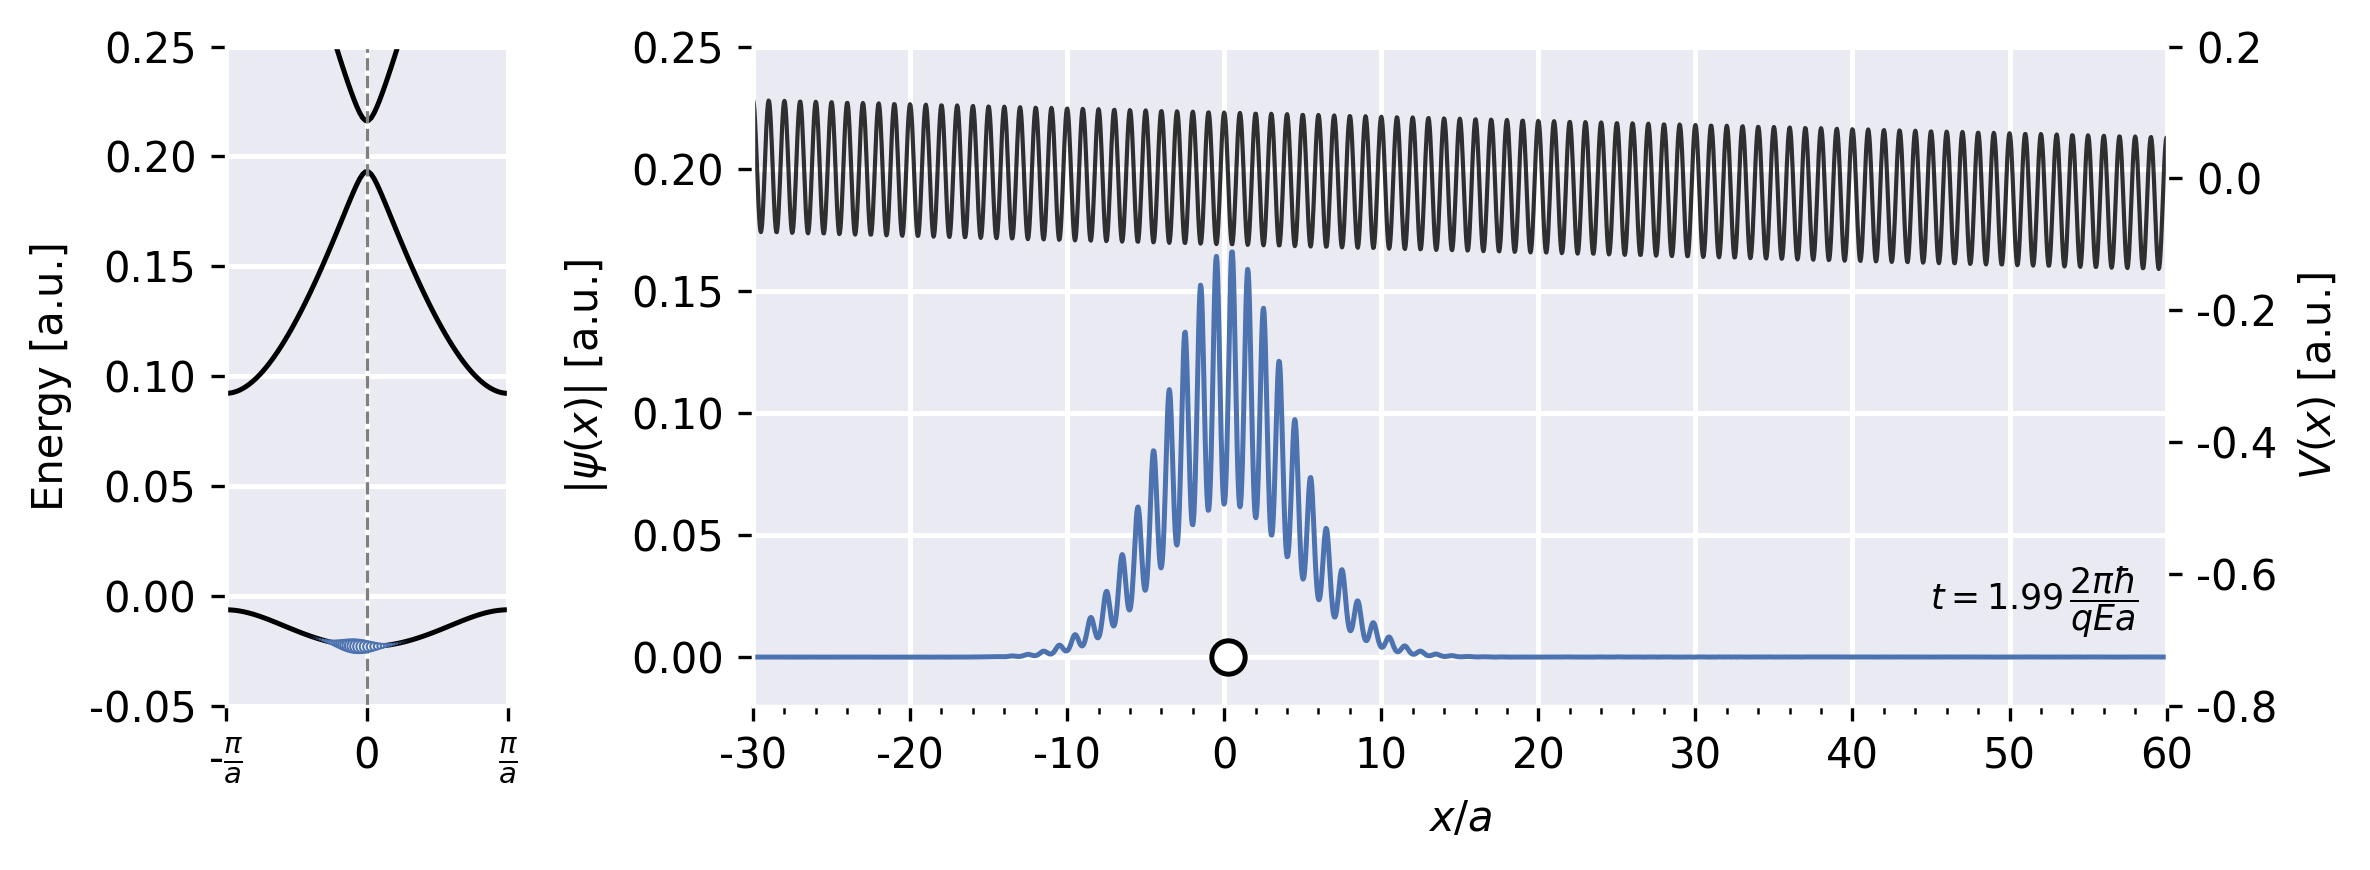

In [130]:
a  = 10
b  = 2*np.pi / a
v0 = 0.05

n0       = 0
k0       = 0
sigma_k  = 0.04
nbnds    = 5
ngx      = 20
kwp, fk  = get_bloch_wavepacket_gaussian_envelop(k0, sigma_k=sigma_k,
        nk=100, Nsigma=10)

Nc       = 150
L        = Nc * a
Nx       = 3999
x        = np.linspace(-0.4*L, 0.6*L, Nx)
dx       = x[1] - x[0]
bloch_wp = construct_blochwp_cosx_pot(x, kwp, fk, a=a, v0=v0, nbnds=nbnds, ngx=20)

k_1d_bz = np.linspace(-0.5, 0.5, 100)
Enk     = []
phi_nk  = []

Gx = np.arange(ngx, dtype=int)
Gx[ngx // 2 + 1:] -= ngx
for k in k_1d_bz:
    e, c = epsilon_nk_cosx_pot(k, a=a, v0=v0, ngx=ngx, nbnds=nbnds, Ngmax=1)
    Enk.append(e)
    cg = c[n0]
    phi_nk.append(
        np.sum(cg[:,None]*np.exp(1j*b*(Gx+k)[:,None] * x[None,:]), axis=0)
    )
Enk = np.asarray(Enk)
phi_nk = np.asarray(phi_nk)

qE     = 2*np.pi / 1E5
Vx     = 2* v0 *np.cos(b*x) - qE*x
dt     = 10
Tbloch = 2 * np.pi / (qE * a)
NSW    = 2 * int(Tbloch / dt)
PSI0   = CrankNicolson(bloch_wp, Vx, x, dt, NSW, False)

X0  = np.sum((np.abs(PSI0)**2) * x[:, None], axis=0) / np.sum((np.abs(PSI0)**2), axis=0)
X0 /= a
np.savetxt('x0_blochwp.dat', np.c_[np.arange(NSW)*dt/Tbloch, X0])

if os.path.isfile('kproj.npy'):
    kwht = np.load('kproj.npy')
    kc   = k_1d_bz[np.argmax(np.abs(kwht), axis=1)]
else:
    kwht = []
    for ii in range(NSW):
        kwht.append(
            np.sum(
                phi_nk.conj() * PSI0[:,ii][None,:],
                axis=1
            )
        )
    kwht = np.array(np.abs(kwht))
    kc   = k_1d_bz[np.argmax(np.abs(kwht), axis=1)]
    np.save('kproj.npy', kwht)

np.savetxt('k0_blochwp.dat', np.c_[np.arange(NSW)*dt/Tbloch, kc])

Nsave  = NSW // 16
np.savetxt('td_blochwp_snapshots.dat', np.c_[x/a, np.abs(PSI0[:,::Nsave])][::2,:],
        fmt='%10.5f')

mpl.rcParams['axes.unicode_minus'] = False

fig = plt.figure(figsize=(8.0, 3.0), dpi=300)

axes = fig.subplot_mosaic(
    [[0, 1]],
    empty_sentinel=None,
    height_ratios=[1],
    width_ratios=[1, 5],
)
axes_list = [axes[ii] for ii in range(2)]

for ax in axes_list:
    ax.set_facecolor('#EAEAF2')
    ax.grid(True, color='white', linewidth=1.2, linestyle='-')
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color('white')

ax = axes_list[0]
ax.axvline(x=0, lw=0.8, ls='--', color='gray')

emin = Enk.min()

for ii in range(nbnds):
    ax.plot(k_1d_bz, Enk[:,ii], color='black', lw=1.2, zorder=1)

scat = ax.scatter(
    k_1d_bz, Enk[:,n0], s=np.abs(kwht[0]) / 3,
    lw=0.5, color=deep_blue, facecolor='white', zorder=2
)

ax.set_xlim(-0.5, 0.5)
ax.set_xticks([-0.5, 0, 0.5], [r'-$\frac{\pi}{a}$', '0',  r'$\frac{\pi}{a}$'])
ax.set_ylim(-0.05, 0.25)
ax.set_ylabel('Energy [a.u.]')

ax = axes_list[1]
axt = ax.twinx()

l0, = ax.plot(x / a, np.abs(PSI0[:,0]), lw=1.2, color=deep_blue)
l1, = ax.plot([X0[0]], [0], ls='none',
        marker='o', ms=8, mew=1.2, mfc='white', mec='black')

axt.plot(x / a, Vx, lw=1.0, label=r'$V(x)$', color='black', alpha=0.8)

ax.xaxis.set_minor_locator(AutoMinorLocator(n=5))

time_stamp = ax.text(
    0.98, 0.10,
    r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(0),
    ha='right', va='bottom',
    family='monospace',
    fontsize='small',
    transform=ax.transAxes,
)

ax.set_ylim(-0.02, 0.25)
axt.set_ylim(-0.80, 0.20)
ax.set_xlim(-30, 60)

ax.set_xlabel(r'$x / a$', labelpad=5)

ax.set_ylabel(r'$|\psi(x)|$ [a.u.]', labelpad=5)
ax.tick_params(axis='y')

axt.set_ylabel(r'$V(x)$ [a.u.]', labelpad=5)
axt.tick_params(axis='y')
axt.spines['right'].set_color('white')
axt.spines['left'].set_color('white')
axt.spines['top'].set_color('white')
axt.spines['bottom'].set_color('white')

plt.tight_layout()

def wfc_propagation(iframe):
    l0.set_ydata(np.abs(PSI0[:,iframe*10]))
    l1.set_xdata([X0[iframe*10]])

    scat.set_sizes(np.abs(kwht[iframe*10]) / 3)

    time_stamp.set_text(
        r'$t={:6.2f}\,\dfrac{{2\pi\hbar}}{{qEa}}$'.format(iframe * 10 * dt / Tbloch),
    )

    return l0, l1, scat, time_stamp,

ani = animation.FuncAnimation(
    fig,
    wfc_propagation,
    interval=40,
    blit=True,
    repeat=True,
    frames=NSW//10,
)
ani.save('bch_osc_tdse_cn.mp4', writer='ffmpeg', dpi=300)
plt.show()